In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
from IPython.display import clear_output
from collections import deque
from tqdm.notebook import tqdm
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K

tf.compat.v1.disable_eager_execution()

## Dueling DQN Architecture

### Main Ideas:

1. **Separation of Value and Advantage**:
   The key idea in the **dueling architecture** is to separate the estimation of:
   - The **value of being in a particular state** (state-value function $ V(s) $).
   - The **advantage of each action** in that state (advantage function \( A(s, a) \)).
   
   The network is split into two streams after a shared layer, where:
   - One stream estimates the state-value \( V(s) \).
   - The other stream estimates the advantage \( A(s, a) \).

2. **Combining Value and Advantage**:
   After the two streams (value and advantage) are computed, they are combined to form the final Q-value. The Q-value is computed using the following formula:
   $$
   Q(s, a) = V(s) + \left( A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \right)
   $$
   The term \( \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \) ensures that the advantage stream is normalized, avoiding redundancy in the Q-value calculation.

3. **Why Dueling Architecture?**
   - In many states, it is unnecessary to know the value of each action explicitly. For example, in some states, any action might have little effect on the outcome.
   - The **dueling network** allows the agent to compute the value of a state without requiring precise Q-value estimates for each action in every state.
   - This results in **more stable learning** and better generalization.

4. **Better Performance in Sparse Reward Environments**:
   - The separation of state-value and advantage helps the agent learn more efficiently, particularly in environments where many actions have similar effects.
   - It is especially useful in **sparse reward environments**, where the difference between actions may not be immediately clear.

### Structure of the Dueling DQN:

- **Shared Layers**: The initial layers are shared, allowing the network to extract features common to both the value and advantage estimations.
- **Value Stream**: A fully connected layer that estimates \( V(s) \), the value of the current state.
- **Advantage Stream**: A fully connected layer that estimates \( A(s, a) \), the advantage of each action given the current state.
- **Output Layer**: Combines the value and advantage streams to produce the Q-values for each action.


In [2]:
class DuelingDQAgent():
    def __init__(self, 
                 observation_space, 
                 action_space,
                 gamma=0.99, 
                 lr=0.001,
                 maxlen = 20000):
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma
        self.lr = lr
        self.buffer = deque(maxlen = maxlen)
        self.model = self.build_model(name='dueling_model')
        self.target_model = self.build_model(name='target_dueling_model')
        
    def update(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, s, a, r, s_, t):
        self.buffer.append([s, a, r, s_, t])

    def get_batch(self, batch_size):
        if len(self.buffer) < batch_size:
            return None
        
        batch = random.sample(self.buffer, k=batch_size)
        
        S = np.array([val[0] for val in batch])
        A = np.array([val[1] for val in batch])
        R = np.array([val[2] for val in batch])
        S_ = np.array([val[3] for val in batch])
        T = np.array([val[4] for val in batch])

        return S, A, R, S_, T
    
    def build_model(self, name):
        input_layer = keras.Input(shape=self.observation_space)
        x = keras.layers.Dense(128, activation='relu')(input_layer)
        x = keras.layers.Dense(128, activation='relu')(x)
        
        # Split into value and advantage streams
        value_fc = keras.layers.Dense(128, activation='relu')(x)
        advantage_fc = keras.layers.Dense(128, activation='relu')(x)
        
        value = keras.layers.Dense(1, activation='linear')(value_fc)
        advantage = keras.layers.Dense(self.action_space, activation='linear')(advantage_fc)
        
        # Combine the value and advantage streams
        output = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        
        model = keras.Model(inputs=input_layer, outputs=output, name=name)
        model.compile(
            optimizer=keras.optimizers.legacy.Adam(learning_rate=self.lr),
            loss='mse'
        )
        return model
    
    def predict(self, observation):
        return self.model.predict(np.array([observation]), verbose=False)[0]
    
    def predict_action(self, observation):
        return np.argmax(self.predict(observation))
    
    def e_greedy(self, observation, e=0.1):
        if random.random() >= e:
            return self.predict_action(observation)
        return random.randint(0, self.action_space-1)
    
    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        # Get a batch from the replay buffer
        S, A, R, S_, T = self.get_batch(batch_size)
        
        # Predict Q-values for current states S using the main model
        Q_values = self.model.predict(S, verbose=False)
        
        # Predict Q-values for next states S_ using the target model
        new_Q = self.target_model.predict(S_, verbose=False)
        max_new_Q = np.max(new_Q, axis=1)
        # # Select the best action using the main model
        # best_actions = np.argmax(self.model.predict(S_, verbose=False), axis=1)
        
        # # Get the Q-values for the selected best actions from the target model
        # max_new_Q = new_Q[np.arange(batch_size), best_actions]
        
        # Update Q-values using the Bellman equation
        Y = Q_values
        for i in range(batch_size):
            if not T[i]:  # If the episode is not done
                Y[i][A[i]] = R[i] + self.gamma * max_new_Q[i]  # Q-learning update
            else:  # If the episode is done
                Y[i][A[i]] = R[i]  # No future reward if terminal state is reached
        
        # Train the model using the updated Q-values
        self.model.fit(S, Y, verbose=False)


In [3]:
env = gym.make("LunarLander-v2")
agent = DuelingDQAgent(env.observation_space.shape, env.action_space.n)

episodes = 2000
max_t = 500
e=0.05
scores = []
avgs = []
time = 0
frequency = 400

for episode in range(episodes):
    observation, _ = env.reset()
    
    score = 0
    for t in range(max_t):
        time += 1
        s = observation
        a = agent.e_greedy(s, e=e)
        observation, reward, terminated, _, _ = env.step(a)
        score +=  reward
        s_ = observation
        agent.remember(s, a, reward, s_, terminated)
        agent.train(batch_size=32)
        if time % frequency == 0:
            agent.update()
        if terminated:
            break
    scores.append(score)
    avgs.append(np.sum(scores[-50:])/len(scores[-50:]))
    print(f"episode: {episode}, e: {e}, t: {t}, score: {score : .2f}, avg score: {avgs[-1]: .2f}")
    if avgs[-1] >= 200:
        break

c:\Users\admin\anaconda3\envs\test\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
c:\Users\admin\anaconda3\envs\test\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0, e: 0.05, t: 86, score: -276.10, avg score: -276.10
episode: 1, e: 0.05, t: 97, score: -94.91, avg score: -185.50
episode: 2, e: 0.05, t: 332, score: -497.63, avg score: -289.55
episode: 3, e: 0.05, t: 200, score: -286.23, avg score: -288.72
episode: 4, e: 0.05, t: 188, score: -13.52, avg score: -233.68
episode: 5, e: 0.05, t: 484, score: -224.21, avg score: -232.10
episode: 6, e: 0.05, t: 411, score: -229.73, avg score: -231.76
episode: 7, e: 0.05, t: 218, score: -53.68, avg score: -209.50
episode: 8, e: 0.05, t: 499, score: -49.25, avg score: -191.69
episode: 9, e: 0.05, t: 161, score: -51.87, avg score: -177.71
episode: 10, e: 0.05, t: 230, score: -43.66, avg score: -165.53
episode: 11, e: 0.05, t: 333, score:  7.07, avg score: -151.14
episode: 12, e: 0.05, t: 219, score: -72.41, avg score: -145.09
episode: 13, e: 0.05, t: 499, score: -45.16, avg score: -137.95
episode: 14, e: 0.05, t: 442, score: -187.85, avg score: -141.27
episode: 15, e: 0.05, t: 499, score: -80.86, av

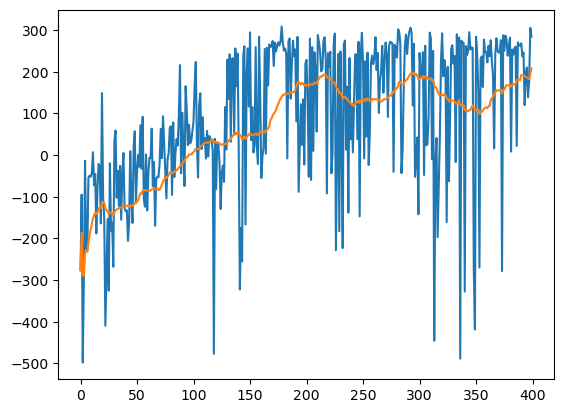

In [4]:
plt.plot(scores)
plt.plot(avgs)
plt.show()

Running test 1/5...
episode: 0, e: 0.05, t: 137, score: -491.34, avg score: -491.34
episode: 1, e: 0.05, t: 54, score: -230.57, avg score: -360.95
episode: 2, e: 0.05, t: 59, score: -102.80, avg score: -274.90
episode: 3, e: 0.05, t: 114, score: -524.25, avg score: -337.24
episode: 4, e: 0.05, t: 168, score: -201.94, avg score: -310.18
episode: 5, e: 0.05, t: 404, score: -60.87, avg score: -268.63
episode: 6, e: 0.05, t: 186, score: -318.92, avg score: -275.81
episode: 7, e: 0.05, t: 169, score: -234.31, avg score: -270.62
episode: 8, e: 0.05, t: 404, score: -21.74, avg score: -242.97
episode: 9, e: 0.05, t: 350, score: -392.29, avg score: -257.90
episode: 10, e: 0.05, t: 381, score: -224.23, avg score: -254.84
episode: 11, e: 0.05, t: 248, score:  22.03, avg score: -231.77
episode: 12, e: 0.05, t: 462, score: -81.29, avg score: -220.19
episode: 13, e: 0.05, t: 499, score:  33.31, avg score: -202.09
episode: 14, e: 0.05, t: 159, score:  17.39, avg score: -187.46
episode: 15, e: 0.05, t

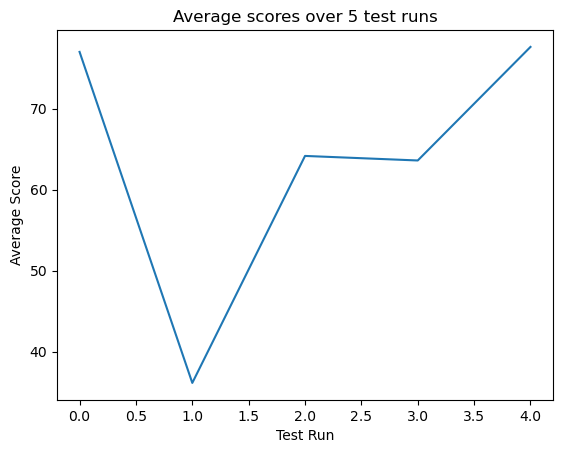

In [5]:
def run_single_test(env, agent, episodes=500, max_t=500, e=0.05, frequency = 400):
    scores = []
    avgs = []
    time = 0 
    for episode in range(episodes):
        observation, _ = env.reset()
        score = 0
        for t in range(max_t):
            time += 1
            s = observation
            a = agent.e_greedy(s, e=e)
            observation, reward, terminated, _, _ = env.step(a)
            score +=  reward
            s_ = observation
            agent.remember(s, a, reward, s_, terminated)
            agent.train(batch_size=32)
            if time % frequency == 0:
                agent.update()
            if terminated:
                break
        scores.append(score)
        avgs.append(np.sum(scores[-50:]) / len(scores[-50:]))
        print(f"episode: {episode}, e: {e}, t: {t}, score: {score: .2f}, avg score: {avgs[-1]: .2f}")


    return scores, avgs

def run_multiple_tests(env, agent_class, num_tests=5, episodes=300, max_t=500, e=0.05):
    all_test_scores = []
    for test in range(num_tests):
        print(f"Running test {test + 1}/{num_tests}...")
        agent = agent_class(env.observation_space.shape, env.action_space.n)
        scores, avgs = run_single_test(env, agent, episodes=episodes, max_t=max_t, e=e)
        all_test_scores.append(np.mean(scores))  # Store the average score for this test

    overall_avg_score = np.mean(all_test_scores)
    print(f"\nAverage score over {num_tests} test runs: {overall_avg_score:.2f}")

    return all_test_scores

env = gym.make("LunarLander-v2")

num_tests = 5

all_test_scores = run_multiple_tests(env, DuelingDQAgent, num_tests=num_tests, episodes=300, max_t=500, e=0.05)

plt.plot(all_test_scores)
plt.title(f'Average scores over {num_tests} test runs')
plt.xlabel('Test Run')
plt.ylabel('Average Score')
plt.show()